## Speed up a real-world problem!

Here your task is to speed up an algorithm for finding the solution to the *Heat Equation* in 2D using a finite-difference method, given an initial temperature distribution.  

the heat equation is defined as:

$$ \frac{du}{dt}  = \alpha \nabla^2 u$$

Where $u$ is the temperature. This can be approximated simply by iterating in time and approximating the spatial gradient using neighboring array elements. For time-step $k$ of width $\Delta t$ and spatial width $\Delta x$:

\begin{equation}
\frac{u^{k+1}_{ij}-u^k_{ij}}{\Delta t}  = \frac{\alpha}{(\Delta x)^2} \left( u^k_{i,j-1} + u^k_{i-1,j} - 4 u^k_{i,j} + u^k_{i+1,j} + u^k_{i,j+1}\right)
\end{equation}

Below we give a naïeve way to solve this, using for-loops (which are not ideal in python). See if you can speed this up by either:

1. re-writing the code to use numpy to get rid of the spatial loops 
2. using cython or numba to compile the function (may need to experiment also with some of their compile options)

You should also try to see what the memory usage is! (hint: use the memory_profiler module). Is there a memory leak?

#### the setup:
set up the initial condtions (defining the temperature at the boundary, as well as some hot-spots that are initially at a particular temperature)

Text(0.5, 1.0, 'initial conditions')

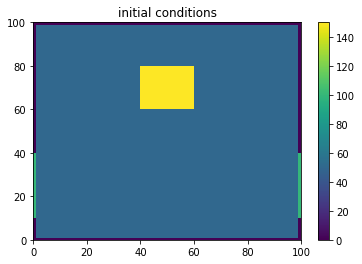

In [14]:
N=100; M=100  # define the spatial grid
grid = np.zeros(shape=(N,M))
grid[10:40,:] = 100 # a hot-spot on the border
grid[1:-1,1:-1] = 50 # some initial temperature in the middle
grid[60:80, 40:60] = 150 # a hot-spot initially heated at the start, that will cool down

plt.pcolormesh(grid)
plt.colorbar()
plt.title("initial conditions")

In [15]:
def solve_heat_equation_loops(init_cond, iterations=100, delta_x=1.0, alpha=1.0):

    delta_t = delta_x**2/(4*alpha)
    prev = np.copy(init_cond)
    cur = np.copy(init_cond)
    N,M = init_cond.shape

    for k in range(iterations):
        for i in range(1,N-1):
            for j in range(1,M-1):
                cur[i,j] = prev[i,j] + alpha*delta_t/delta_x**2 * (
                    prev[i,j-1] + prev[i-1,j] - 4*prev[i,j] + prev[i,j+1] + prev[i+1,j]
                )
        
        prev,cur = cur,prev  #swap pointers

    return prev

We'll also define a convenience function to test the results (you can use this same plotter with your own solver)

In [16]:
def plot_heat_equation(solver, iters=(2,10,100,1000)):
    
    fig, axes = plt.subplots(1,len(iters), figsize=(15,3))

    for ii, iterations in enumerate(iters):
        result = solver(init_cond=grid, iterations=iterations)
        axes[ii].pcolormesh(result, vmin=0, vmax=100)
        axes[ii].set_title("{} iterations".format(iterations))



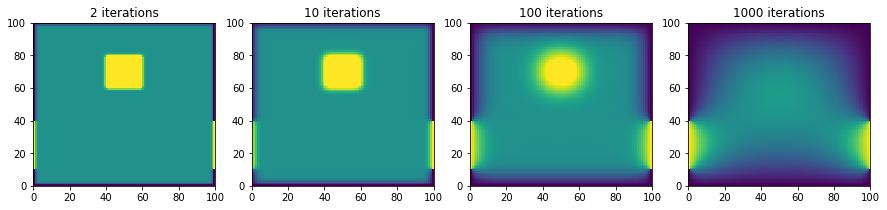

In [17]:
plot_heat_equation(solver=solve_heat_equation_loops)

Note that our code is quite slow... 

### Your turn!

***Write an improved verson***

* how much faster is your version on average?
* how much memory does it use on average? Is it more than the loop version?
* which line is the slowest line? 

(hint: if done right, you should get a factor of about 100 speed increase)

In [18]:
def my_heat_equation_solver(init_cond, iterations=100, delta_x=1.0, alpha=1.0):
    ## your code here
    return init_cond # replace with real return value

In [19]:
#plot_heat_equation(solver=my_heat_equation_solver)

### SOLUTION

there are many ways to achieve this...

In [20]:
results = {}
r = %timeit -o solve_heat_equation_loops(grid, iterations=50)
results['loop'] = r

601 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### using Numba:

In [21]:
from numba import jit
solve_heat_equation_numba = jit(solve_heat_equation_loops)

In [22]:
r = %timeit -o solve_heat_equation_numba(grid, iterations=50)
results['numba'] = r

1.46 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### using cython:

In [23]:
%load_ext cython

In [24]:
%%cython 

cimport numpy as cnp
import numpy as np

def solve_heat_equation_cython(init_cond, int iterations=100, double delta_x=1.0, double alpha=1.0):

    cdef int i,j,k, N, M
    cdef float delta_t
    cdef cnp.ndarray[double, mode="c", ndim=2] prev, cur  # this seems to give the biggest improvement

    delta_t = delta_x**2/(4*alpha)
    prev = np.copy(init_cond)
    cur = np.copy(init_cond)
    N,M = init_cond.shape

    for k in range(iterations):
        for i in range(1,N-1):
            for j in range(1,M-1):
                cur[i,j] = prev[i,j] + alpha*delta_t/delta_x**2 * (
                    prev[i,j-1] + prev[i-1,j] - 4*prev[i,j] + prev[i,j+1] + prev[i+1,j]
                )
        
        prev,cur = cur,prev

    return prev
                                                                



In [25]:
r = %timeit -o solve_heat_equation_cython(grid, iterations=50)
results['cython'] = r

1.54 ms ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### with numpy

using range-slicing `array[start:end,start:end]` we can get rid of the inner for-loops and turn that part into vector operations

In [26]:
def solve_heat_equation_numpy(init_cond,  iterations=100,  delta_x=1.0, alpha=1.0):

    delta_t = delta_x**2/(4*alpha)
    prev = np.copy(init_cond)
    cur = np.copy(init_cond)

    # define some slices to make it easier to type 
    # just avoids too many things like prev[1:-1,1:-1])
    z = slice(1,-1) # zero
    p = slice(2,None) # plus 1
    m = slice(0,-2) # minus 1

    for k in range(iterations):
        cur[z,z] = (
            prev[z,z] + alpha*delta_t/delta_x**2 * (
                prev[z,m] + prev[m,z] - 4.0*prev[z,z] + prev[z,p] + prev[p,z]
            )
        )
        prev,cur = cur,prev # swap the pointers

    return prev # since we swapped, prev is the most recent

In [27]:
r = %timeit -o solve_heat_equation_numpy(grid, iterations=50)
results['numpy'] = r

2.91 ms ± 41.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[]

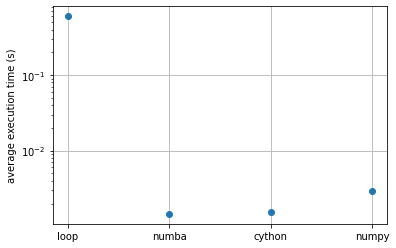

In [66]:
plot_performance(results)
plt.semilogy()

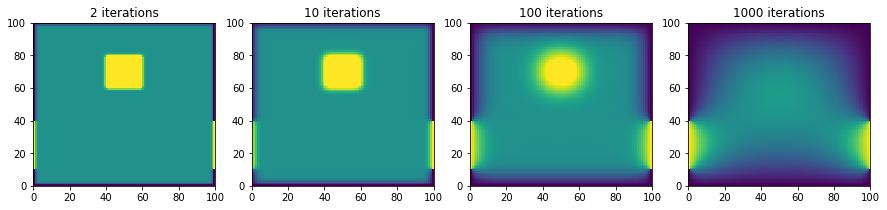

In [29]:
plot_heat_equation(solver=solve_heat_equation_numba)

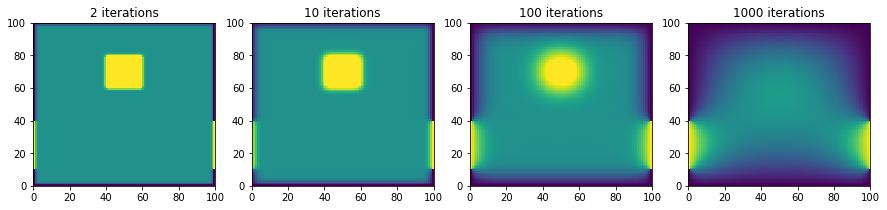

In [30]:
plot_heat_equation(solver=solve_heat_equation_cython)

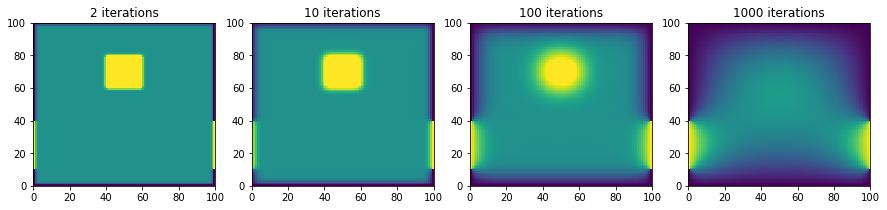

In [31]:
plot_heat_equation(solver=solve_heat_equation_numpy)

Lets look at memory usage:

In [33]:
%load_ext memory_profiler


In [34]:
%memit solve_heat_equation_numpy(grid, 5000)

peak memory: 373.66 MiB, increment: 0.06 MiB


In [35]:
%memit solve_heat_equation_loops(grid, 5000)

peak memory: 373.66 MiB, increment: 0.00 MiB
